RNN Example Time Series

In addition to the examples we've seen in this unit, where we reference sequential data texts,
there are more use cases for which an RNN is useful. Another example is time series. This data,
although from the beginning are structured and numerical data, have the peculiarity that part of
there is a temporal order that is important to be able to capture in the models. So, if we talk about,
for example, temperature predictions on different days, we know that the measurement on a
particular day is not independent of the measurement the previous day and will also be related to
the temperature measurement of the next day. This data is not independent and is therefore not
i.i.d (independent and identically distributed). Being therefore sequential data, they are also good
candidates to use within an RNN.
As an example, we will use the Kaggle https://www.kaggle.com/rajatdey/jaipur-weatherforecastingdataset, which collects measurements of various environmental variables over
different days between May 1, 2016 and May 11, 2018, for the Jaipur region in India. The
average temperature is included in the available variables.
With this, we will build an RNN to predict that average temperature. The evolution of this
temperature will be influenced by different factors (relative humidity, pressure...), but we can build
univariate prediction. That is, predict the average temperature by taking as information the
evolution of the temperature itself in the past for each specific day.
First, we import the relevant classes to build an RNN. In this case, we will use the LSTM as NN
units, so, on common classes that we have used so far, we additionally import from Keras a class
to incorporate these units into the network.

In [2]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



After that, we load the data set and visualize the evolution of the variable of interest, the average
temperature. In addition, as with any NN, we standardize the data (although in this case, when
working only with a variable, it would not be essential)

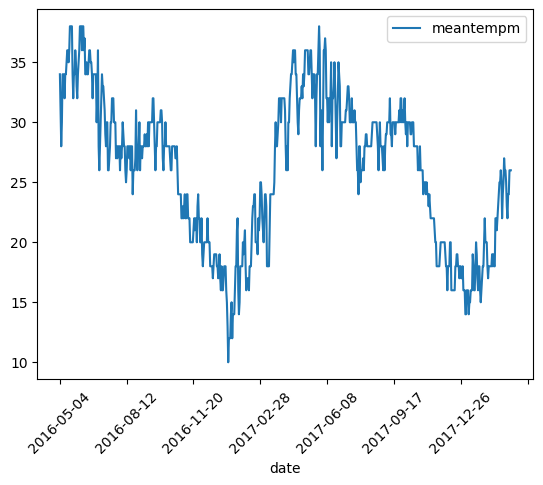

In [3]:
#============================================================================
# 1. Load & prepare data
#============================================================================
# Set seed
tf.random.set_seed(42)

# Load data
# df_raw = pd.read_csv("{0}/AirPassengers.csv".format(path_folder))
# Define params
path_folder = "jaipur-weather-forecasting"
col_feature = 'meantempm'
col_datetime = 'date'
# Load data
df_raw = pd.read_csv("JaipurFinalCleanData.csv")
df_raw = df_raw.sort_values(by=[col_datetime], ascending=True)

# Plot data
df_raw.plot(x=col_datetime, y=col_feature, rot=45)
# Standarize the dataset
scaler = StandardScaler()
df_input = df_raw.copy()
df_input[col_feature] = scaler.fit_transform(df_input[col_feature].values.reshape(-1, 1))
df_input = pd.Series(data=df_input[col_feature].values)

As we can see, the evolution of average temperatures per day follows a fairly seasonal pattern. Its maximum value is reached between May-June, and previously until these dates it has been increasing, and after them it decreases again. Decreases to a minimum of 15ºC or 10ºC near December.



The next step is to separate the dataset into train/test. When working with sequences, it is common to use the first historical data as training data and reserve the latest historical data as ground truth to check the efficiency of the same. We use 80% of the data for the model to train, and we will test the last 20% of the data in the sequence


In [4]:
# Train/Test split
train_size = int(len(df_input) * 0.8)
test_size = len(df_input) - train_size
df_train, df_test = df_input[0:train_size],df_input[train_size:len(df_input):]
print(len(df_train), len(df_test))

540 136


After this, the next step is to build the variables that will be used to predict the evolution of the
average temperature. Since we are using only the evolution of the temperature itself (univariate
case), the historical data will be the ones that serve us to predict the future. Thus, the idea will
be, starting from a data window in the past, to be able to predict the temperature for the next day.
We can understand this more with the following example.

----

Based on a 5-day time window, the prediction model will use the previous 5 days as input
variables, and with them it will predict the day after them. In this way, the array of input-output
variables using this 5-day time window is as follows for the prediction of 6 specific days. The first
5 days are used as variables to predict the 6th, from day 1 to 6 are used to predict the 7th, and
so on

To do this, we create a function that receives the input string and that, defining that window size,
builds the matrix of the previous image, with which we have the input and output variables.

In [5]:
def univariate_data(dataset, start_index, end_index, history_size,target_size):
  """
  Function to obtain the features matrix based on the input univariate sequence.
  Starting from said sequence, and for an interval of the same  based on specified indices
  Input:  dataset, start_index, end_index, history_size, target_size

  """
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[min(indices):max(indices)+1].values,(history_size, 1)))
    labels.append(dataset[i+target_size])

  return np.array(data), np.array(labels)

# Generate features
n_past_history = 20
n_future_target = 0
x_train, y_train = univariate_data(dataset = df_input,start_index = 0,end_index = train_size,history_size = n_past_history,target_size = n_future_target)
x_test, y_test = univariate_data(dataset = df_input,start_index = train_size,end_index = None,history_size = n_past_history,target_size = n_future_target)

As we can see, we have considered a window size of 20, so we are using the 20 days prior to a
particular day to predict it.
The next step is to use the Keras tf.data() function to move from the original data array we
previously obtained to a tensioner that TensorFlow can work with. The RNN will receive in each
iteration the input variables for all stages considered, in subsets of data according to its
batch_size

In [6]:
# Transform to tensor
batch_size = 25
train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.batch(batch_size).repeat()
test_univariate = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_univariate = test_univariate.batch(batch_size).repeat()

Defined the data entry, you proceed to create an RNN in which LSTM is used as units of it. To do
this, we define a function that, when instantiated, provides us with the NN object.

In [7]:
#============================================================================
# 0. General functions
#============================================================================
def create_rnn_model(x_input, n_lstm=8, loss='mean_squared_error', optimizer='adam'):
 """
 Function for creating the RNN. As input parameter it only needs the feature matrix to specify
 the dimensionality for specifying the input for the NN.
 Returns
 -------
 model : object
 Trained model.
 Parameters
 ----------
 x_input : array
 Input feature matrix..
 n_lstm : int, optional
 Number of lstm used. The default is 8.
 loss : string, optional
 loss metric. The default is 'mean_squared_error'.
 optimizer : string, optional
 optimizer. The default is 'adam'.
 Returns
 -------
 model : object
 Trained model.
 """
 # Begin sequence
 model = tf.keras.Sequential()

 # Add a LSTM layer with 8 internal units.
 model.add(LSTM(n_lstm, input_shape=x_input.shape[-2:]))

 # Output
 model.add(Dense(1))

 # Compile model
 model.compile(loss=loss, optimizer=optimizer)

 return model

And with that, we generate the NN, train it, and store the obtained model.

In [8]:
#============================================================================
# 2. Train RNN
#============================================================================
# General params
evaluation_interval = 30
epochs = 100
steps_per_epoch = 10
# Create RNN
model = create_rnn_model(x_train)
model.summary()
# Fit RNN
model.fit(train_univariate,epochs=epochs,steps_per_epoch=steps_per_epoch)
# Save file
model.save('model_forecast_weather.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 3s 9ms/step - loss: 0.7459
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 0.5564
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 0.4520
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 0.6458
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 0.3079
Epoch 6/100
10/10 [===

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


With this, we can evaluate the efficiency of the model. We first get the predictions for the test
data,and with it we calculate several regression metrics.

In [9]:
#============================================================================
# Evaluate
#============================================================================
# Obtain predictions
y_pred = model.predict(x_test)
y_pred = [x[0] for x in y_pred] # change output format
df_preds = pd.DataFrame({'y_pred':y_pred, 'y_test':y_test})
# Set indexes with the date
df_preds.index = df_raw[train_size+n_past_history:][col_datetime].values

# Obtain metrics
mse = mean_squared_error(y_test, y_pred)


mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE: ", mse)
print("MAE: ", mae)
print("R2: ", r2)

4/4 [==============================] - 1s 5ms/step
MSE:  0.06296437717078864
MAE:  0.2026188707375754
R2:  0.7512571776154591


As we can see, without having made a very deep adjustment, the results are quite acceptable.
Finally, we can visualize the comparative evolution of the test data with our predictions. To do this, we first unscale the data and then visualize both series.

In [10]:
# Unscale data
df_preds['y_pred'] = scaler.inverse_transform(df_preds['y_pred'])
df_preds['y_test'] = scaler.inverse_transform(df_preds['y_test'])
# Plot results
df_preds.plot(rot=45)

ValueError: ignored

In [ ]:
# Unscale data
df_preds['y_pred'] = scaler.inverse_transform(df_preds['y_pred'])
df_preds['y_test'] = scaler.inverse_transform(df_preds['y_test'])
# Plot results
df_preds.plot(rot=45)